# Step #1 Load the House Price Data

In [31]:
# A tutorial for this file is available at www.relataly.com

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn import svm
from sklearn.ensemble import RandomForestRegressor

# Source: 
# https://www.kaggle.com/c/house-prices-advanced-regression-techniques

# Load train and test datasets
path = "https://raw.githubusercontent.com/flo7up/relataly_data/main/house_prices/train.csv"
df = pd.read_csv(path)
print(df.columns)
df.head()

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Step #2 Explore the Data

Text(0.5, 1.0, 'Sale Price Distribution')

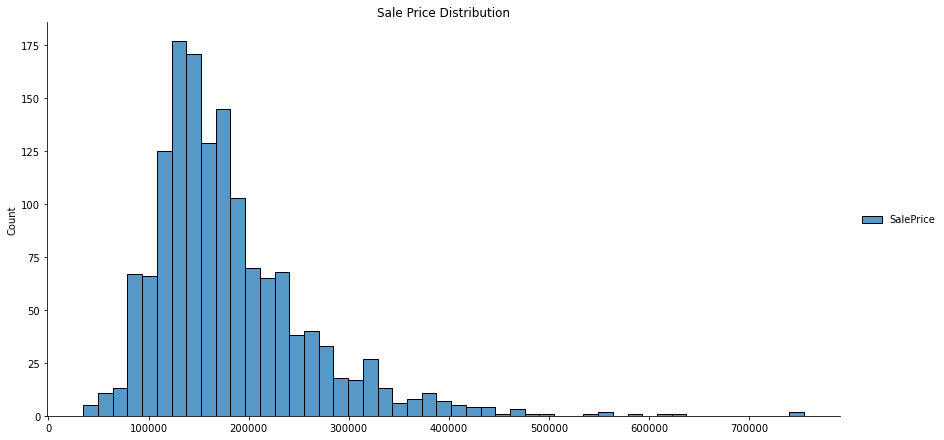

In [2]:
# Create histograms for feature columns separated by prediction label value
ax = sns.displot(data=df[['SalePrice']].dropna(), height=6, aspect=2)
plt.title('Sale Price Distribution')

Text(0.5, 1.0, 'Overall Quality vs LotArea depending on Sale Price')

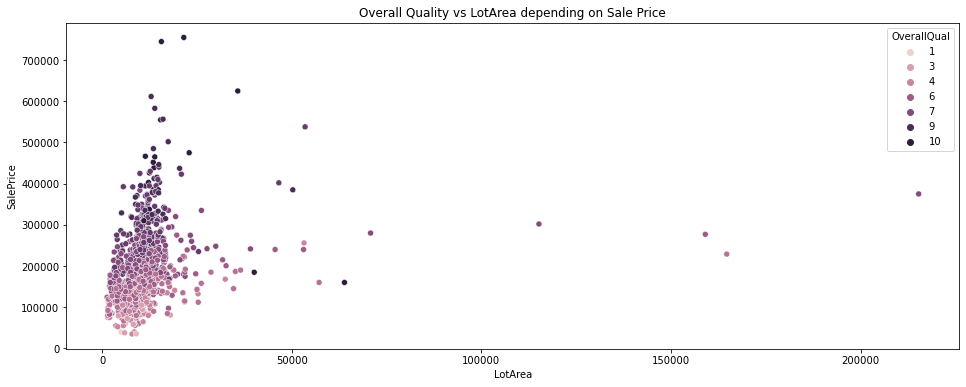

In [68]:
# Create histograms for feature columns separated by prediction label value
plt.figure(figsize=(16,6))
df_features = df[['SalePrice', 'LotArea', 'OverallQual']]
sns.scatterplot(data=df_features, x='LotArea', y='SalePrice', hue='OverallQual')
plt.title('Overall Quality vs LotArea depending on Sale Price')

# Step #3 Data Preprocessing

In [4]:
def preprocessFeatures(df):   
    # Define a list of relevant features
    feature_list = ['SalePrice', 'OverallQual', 'Utilities', 'GarageArea', 'LotArea', 'OverallCond', 'SalePrice']
    df_dummy = pd.get_dummies(df[feature_list]).drop(['SalePrice'], axis=1)
    # Cleanse records with na values
    #df_prep = df_prep.dropna()
    label_col = df['SalePrice']
    return df_dummy, label_col

df_base, label_col = preprocessFeatures(df)

# Split the data into x_train and y_train data sets
x_train, x_test, y_train, y_test = train_test_split(df_base, label_col, train_size=0.7, random_state=0)
x_train.head()

,OverallQual,GarageArea,LotArea,OverallCond,Utilities_AllPub,Utilities_NoSeWa
682,6,431,2887,5,1,0
960,5,0,7207,7,1,0
1384,6,280,9060,5,1,0
1100,2,246,8400,5,1,0
416,6,440,7844,7,1,0


# Step #4 Train Several Regression Models using Random Search

In [42]:
# Define the Estimator and the Parameter Ranges
dt = RandomForestRegressor()
number_of_iterations = 20
max_leaf_nodes = [2, 3, 4, 5, 6, 7]
min_samples_split = [5, 10, 20, 50]
max_depth = [5,10,15,20]
max_features = [3,4,5]
n_estimators = [50, 100, 200]

# Define the param distribution dictionary
param_distributions = dict(max_leaf_nodes=max_leaf_nodes, 
                           min_samples_split=min_samples_split, 
                           max_depth=max_depth,
                           max_features=max_features,
                           n_estimators=n_estimators)

# Build the gridsearch
grid = RandomizedSearchCV(estimator=dt, 
                          param_distributions=param_distributions, 
                          n_iter=number_of_iterations, 
                          cv = 5)

grid_results = grid.fit(x_train, y_train)

# Summarize the results in a readable format
print("Best params: {0}, using {1}".format(grid_results.cv_results_['mean_test_score'], grid_results.best_params_))
results_df = pd.DataFrame(grid_results.cv_results_)

Best params: [0.68738293 0.49581669 0.52138751 0.61235299 0.65360944 0.61165147
 0.70392285 0.52278886 0.67687248 0.68219638 0.70031536 0.65842909
 0.51939338 0.70801017 0.70911805 0.69543885 0.67983801 0.60744371
 0.68270285 0.70741042], using {'n_estimators': 100, 'min_samples_split': 5, 'max_leaf_nodes': 7, 'max_features': 3, 'max_depth': 15}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_max_leaf_nodes,param_max_features,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.049196,0.002071,0.004074,0.000820,50,20,5,4,15,"{'n_estimators': 50, 'min_samples_split': 20, ...",0.662973,0.705533,0.669520,0.702608,0.696280,0.687383,0.017637,7
1,0.041115,0.000554,0.003046,0.000094,50,50,2,3,10,"{'n_estimators': 50, 'min_samples_split': 50, ...",0.490984,0.527231,0.426270,0.523086,0.511513,0.495817,0.036978,20
2,0.043325,0.000779,0.003486,0.000447,50,50,2,5,20,"{'n_estimators': 50, 'min_samples_split': 50, ...",0.484524,0.559358,0.485459,0.517253,0.560343,0.521388,0.033545,18
3,0.162083,0.005665,0.012420,0.004788,200,5,3,3,20,"{'n_estimators': 200, 'min_samples_split': 5, ...",0.586586,0.638341,0.573437,0.626793,0.636608,0.612353,0.027021,14
4,0.166659,0.003026,0.010958,0.000084,200,10,4,3,15,"{'n_estimators': 200, 'min_samples_split': 10,...",0.633305,0.679161,0.623236,0.661864,0.670481,0.653609,0.021636,13


# Step #5 Select the best Model and Measure Performance

In [67]:
# Select the best Model and Measure Performance
best_model = grid_results.best_estimator_
y_pred = best_model.predict(x_test)
y_df = pd.DataFrame(y_test)
y_df['PredictedPrice']=y_pred
y_df.head()

,SalePrice,PredictedPrice
529,200624,166037.831002
491,133000,135860.757958
459,110000,123030.336177
279,192000,206488.444327
655,88000,130453.604206


In [41]:
# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_pred, y_test)
print('Mean Absolute Error (MAE): ' + str(np.round(MAE, 2)))

# Mean Absolute Percentage Error (MAPE)
MAPE = mean_absolute_percentage_error(y_pred, y_test)
print('Median Absolute Percentage Error (MAPE): ' + str(np.round(MAPE*100, 2)) + ' %')

Mean Absolute Error (MAE): 29591.56
Median Absolute Percentage Error (MAPE): 15.57 %
